# CNT WORK

## TDS AS PREDICTIVE PROBE FOR CNT FIBRE STRENGTH, ML

In [792]:
import h5py
import numpy as np
import pandas as pd
from scipy import interpolate
from matplotlib import pyplot as plt

data = h5py.File("CNTs_15062022.tprj", 'r')
data = data['TerapulseDocument']['Measurements']['Spectra Data']

What's the structure of our data?

In [793]:
#list(data.keys())

## Time domain data


<div class="alert alert-block alert-info">
Initially, let's try performing some machine learning on time domain data. For time domain data, the variation in `y` is localised to a few points in `x`. This is the terahertz pulse. For this reason, feature extraction may be an issue. 
</div>

#### Cleaning our data

Separate our data into a single array of names, x-values and y-values. 

In [794]:
rawnameslist = []
rawXslist = []
rawYslist = []

refX, refY = np.array(data['SPECTRA-2147483626']['reference']['sample']['xdata'][:]).squeeze(), \
np.array(data['SPECTRA-2147483626']['reference']['sample']['ydata'][:]).squeeze()
ref = pd.DataFrame({'refx' : refX, 'refy' : refY})

for name in data:
    name, spectraX, spectraY = data['%s' %name]['sample'].attrs.__getitem__('SampleName')[0][0], \
    np.array(data['%s' %name]['sample']['xdata'][:]).squeeze(), \
    np.array(data['%s' %name]['sample']['ydata'][:]).squeeze()
    rawnameslist.append(name), rawXslist.append(spectraX), rawYslist.append(spectraY)

<div class="alert alert-block alert-info">
Now we have our datasets as: 

    -  rawnameslist: labelled data [dataset1, dataset2 ,..., datasetn]
    -  rawXslist: x-values: [[dataset1] ,..., 
            [datasetn]]
    -  rawYslist: y-values: [[dataset1] ,..., 
            [datasetn]]
</div>

Now, we want to put this into a DF

In [795]:
rawYs = pd.DataFrame(rawYslist).transpose()
rawXs = pd.DataFrame(rawXslist).transpose()
rawnames = pd.DataFrame(rawnameslist).transpose()

We only want the materials that we have measured the fibre strength on. These materials are the `names.iloc[:,7:]` indices. So, let's clean up a little bit. We also want to cast the `names` values to the `Ys` and `Xs` column headers.

In [796]:
rawYs, rawXs, rawnames = rawYs.iloc[:,7:], rawXs.iloc[:,7:], rawnames.iloc[:,7:]
rawYs.columns = rawnames.iloc[0,:]
rawXs.columns = rawnames.iloc[0,:]

Notice that there are some repeat materials in rawnames, so we can average these and merge them into the same col.

- 17051859main004_sam4, 17051859main004_sam1 [:,0] and [:,1]
- 220218510star014_striped, 220218510star014 [:,5] and [:,6]
- 170518511main041_striped, 170518511main041 [:,8] and [:,8]

In [797]:
Xs = rawXs.copy()
Xs["17051859main004"] = rawXs[["17051859main004_sam4", "17051859main004_sam1", "17051859main004"]].mean(axis=1)
Xs["220218510star014"] = rawXs[["220218510star014_striped", "220218510star014"]].mean(axis=1)
Xs["170518511main041"] = rawXs[["170518511main041_striped", "170518511main041"]].mean(axis=1)
Xs.drop(["17051859main004_sam4", "17051859main004_sam1", "220218510star014_striped", 
          "170518511main041_striped"], inplace=True, errors='ignore', axis=1)

Ys = rawYs.copy()
Ys["17051859main004"] = rawYs[["17051859main004_sam4", "17051859main004_sam1", "17051859main004"]].mean(axis=1)
Ys["220218510star014"] = rawYs[["220218510star014_striped", "220218510star014"]].mean(axis=1)
Ys["170518511main041"] = rawYs[["170518511main041_striped", "170518511main041"]].mean(axis=1)
Ys.drop(["17051859main004_sam4", "17051859main004_sam1", "220218510star014_striped", 
          "170518511main041_striped"], inplace=True, errors='ignore', axis=1)

Now our names list must be updated in the same way. 

In [798]:
names = rawnames.copy()
names = names[names.isin(["17051859main004_sam4", "17051859main004_sam1", "220218510star014_striped", 
           "170518511main041_striped"]) == False]
names = names.dropna(axis=1)

#### Interpolation

Now, let's interpolate all of our data to a single set of `x` 'master' or 'reference' values. Here, I'm choosing `17051859main004`. We also want a new dataframe `df` with a single set of x values and a set of y values for each dataset. We also want to inerpolate our `refx` and `refy` values so that when we come to normalise by `refy`, the `x` values align. 

In [946]:
df = pd.DataFrame({'x' : Xs['17051859main004']})

In [947]:
refinterp = interpolate.interp1d(x = ref['refx'], y = ref['refy'], kind = 'slinear', \
                            bounds_error=False, fill_value="extrapolate")
ref['refy'] = refinterp(Xs['17051859main004'].tolist())
ref['refx'] = Xs['17051859main004']

for columns in Xs.columns:
    f = interpolate.interp1d(x = Xs['%s' %columns], y = Ys['%s' %columns], kind = 'slinear', \
                             bounds_error=False, fill_value="extrapolate")
    df['%s' %columns] = f(Xs['17051859main004'].tolist())

Lots of our data is centred around 0 along `y`. Let's discard this data. We have to reset our index, so that our data started from 0 and aligns with `dftran` and `dftranscaled`.

Here, we can quickly create the `dfref` DF, where our `y` values are normalised to our `refy` values, which should correct for the system response of our spectrometer.

In [801]:
dfref = df.copy()
dfref.iloc[:,1:] = df.iloc[:,1:].div(ref['refy'], axis=0)
dfref = dfref[(dfref['x'] < -10) & (dfref['x'] > -15)].reset_index(drop=True)

In [1037]:
fftdf = df.copy() # copy this for our FFT later (we chop df up below)

<AxesSubplot:xlabel='x'>

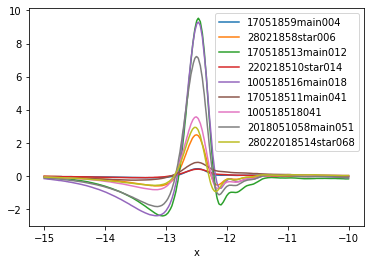

In [802]:
df = df[(df['x'] < -10) & (df['x'] > -15)].reset_index(drop=True)
df.plot(x='x')

#### Feature scaling

For spectroscopy data, our dataframe `df` must be transposed. This is because our 'features' are actually our individual data points. Transposing means we can add an additional column to the end of our dataset `y` which is our target variable. In this case `y` is our `fibre strength`. Before we do this though, we should perform feature scaling.

In [803]:
from sklearn.preprocessing import scale, StandardScaler

dftran = df.copy()
dftran.drop('x',axis=1,inplace=True)
dftran = dftran.transpose()

scaler = StandardScaler()
scaler.fit(dftran)
dftranscaled = pd.DataFrame(scaler.transform(dftran), index=dftran.index)

dftranscaled['fibre strength'] = [4,6,12,14,18,41,41,51,68]

Let's make sure our scaled data looks sensible.

<AxesSubplot:xlabel='x'>

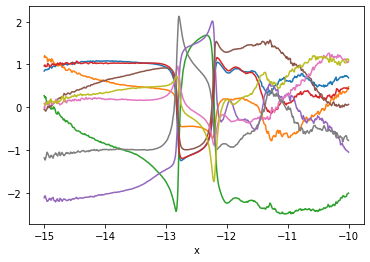

In [804]:
dftranscaledplot = dftranscaled.transpose()
dftranscaledplot['x'] = df['x']
dftranscaledplot.plot(x='x', legend=False)

#### ML on time-domain data

Let's break our data into training and test (25%) datasets.

In [805]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dftranscaled.iloc[:,:-1], dftranscaled['fibre strength'], shuffle=True, random_state=101)

Neural network regressor:

In [806]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

nnmodel = MLPRegressor(hidden_layer_sizes=(300,100), random_state=30, max_iter=500, tol=1e-5).fit(X_train, y_train)
nnmodel.score(X_test, y_test)

-0.8497990782707434

A linear regressor:

In [807]:
linearmodel = LinearRegression(fit_intercept=True).fit(X_train,y_train)
linearmodel.score(X_test, y_test)

-5.463028758838378

In [808]:
predictions = {'nn': nnmodel.predict(X_test), 'linear':linearmodel.predict(X_test)}
print(predictions, "\n", y_test.values)

{'nn': array([10.27210595,  9.4465473 , 29.96339268]), 'linear': array([ 18.44650334, -68.59653422,  28.8605222 ])} 
 [51 12  4]


In [809]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_test, predictions["nn"])
error

779.7930781065778

## Spectral data


<div class="alert alert-block alert-info">
We've just performed regression on the time-domain pulse. It may be that the features which predict fibre strength are more prominent in the frequency-domain. Let's try Fourier transforming our data and performing regression again. 
</div>

#### Cleaning our data

In [1033]:
def FFT(df, refdf):
    """
    Takes df in format:            Takes a refdf in format:
    ---------------------------    ---------------
    | x | y1 | y2 | ... | y_n |    | refx | refy |
    ---------------------------    ---------------
    x and refx should be 1D interpolated to 
    be the same
    """
    dffreq = df.copy()
    dfreal = pd.DataFrame()
    dfimag = pd.DataFrame()
    dfabs = pd.DataFrame()
    
    N = len(dffreq['x'])
    deltatime = abs(dffreq['x'].diff(periods=1).mean()) 

    refY = refdf['refy']
    
    zeropad = 0;
    
    freq = np.arange(0,N+zeropad)/(deltatime*1E-12)/(N+zeropad)
    n_oneside = (N+zeropad)//2

    zeroseries = pd.Series(np.zeros(zeropad)) 
    Tref = np.fft.fft(pd.concat([refY, zeroseries]),N+zeropad)
    
    dffreq = dffreq.drop(columns='x')
    
    ns = 1
    for columns in dffreq.columns:
        Tfreq = np.fft.fft(pd.concat([dffreq["%s" %columns],zeroseries]),N+zeropad)
        TF = (Tfreq/Tref)
        dfabs['%s' %columns] = np.sqrt((((ns+1)/377)*np.real(TF))**2  + (-((ns+1)/377)*np.imag(TF))**2)
        dfimag['%s' %columns] = -((ns+1)/377)*np.imag(TF)
        dfreal['%s' %columns] = ((ns+1)/377)*np.real(TF)
        
        
    dffreq['freq'] = freq
    dfreal['freq'] = freq
    dfimag['freq'] = freq
    dfabs['freq'] = freq
    
    # get our transfer function, and return only the one-sided FFT
    # real = ((ns+1)/377)*np.real(TF)
    # imag = -((ns+1)/377)*np.imag(TF)
    # return freq[:n_oneside], real[:n_oneside], imag[:n_oneside]
    return dfabs.iloc[:n_oneside,:], dfreal.iloc[:n_oneside,:], dfimag.iloc[:n_oneside,:]

<AxesSubplot:xlabel='freq'>

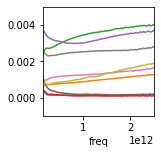

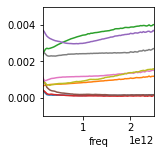

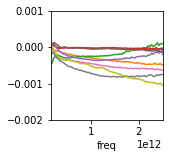

In [1034]:
dffreq, dfreal, dfimag = FFT(fftdf, ref)
dffreq.plot(legend=False, x='freq', xlim=[0.15E12, 2.5E12], ylim=[-0.001,0.005], figsize=(2,2))
dfreal.plot(legend=False, x='freq', xlim=[0.15E12, 2.5E12], ylim=[-0.001,0.005], figsize=(2,2))
dfimag.plot(legend=False, x='freq', xlim=[0.15E12, 2.5E12], ylim=[-0.002,0.001], figsize=(2,2))

#### Feature scaling

We're only interested in frequencies between 0.15 THz and 2.5 THz. We don't want to feature scale before this, because data outside of these regions in 'junk' after we've FFTd it.

In [1039]:
dffreqtran = dffreq.copy()
dffreqtran = dffreqtran[(dffreqtran['freq'] < 2.5E12) & (dffreqtran['freq'] > 0.15E12)]
dffreqtran.drop('freq',axis=1,inplace=True)
dffreqtran = dffreqtran.transpose()

fftscaler = StandardScaler()
fftscaler.fit(dffreqtran)
dffreqtranscaled = pd.DataFrame(fftscaler.transform(dffreqtran), index=dffreqtran.index)

dffreqtranscaled['fibre strength'] = [4,6,12,14,18,41,41,51,68]

Let's make sure our scaled data looks sensible

<AxesSubplot:xlabel='freq'>

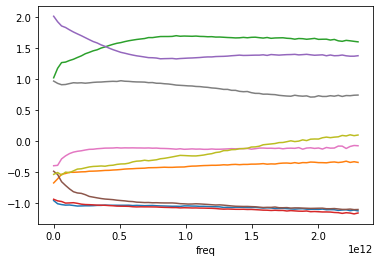

In [1040]:
dffreqtranscaledplot = dffreqtranscaled.transpose()
dffreqtranscaledplot['freq'] = dffreq['freq']
dffreqtranscaledplot.plot(x='freq', legend=False)

#### ML on frequency domain data

Let's break our data up into training and test datasets

In [1045]:
from sklearn.model_selection import train_test_split

freq_train, freq_test, amp_train, amp_test = train_test_split(dffreqtranscaled.iloc[:,:-1], 
                                                              dffreqtranscaled['fibre strength'], 
                                                              shuffle=True, random_state=101)

Neural network regressor:

In [1074]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

fftnnmodel = MLPRegressor(hidden_layer_sizes=(300), random_state=50, 
                          max_iter=5000, tol=1e-5).fit(freq_train, amp_train)
fftnnmodel.score(freq_test, amp_test)

-0.4536108002066708

Linear regressor:

In [1075]:
fftlinearmodel = LinearRegression(fit_intercept=True).fit(freq_train, amp_train)
fftlinearmodel.score(freq_test, amp_test)

-0.4297619158498891

In [1076]:
fftpredictions = {'nn': fftnnmodel.predict(freq_test), 'linear':fftlinearmodel.predict(freq_test)}
print(fftpredictions, "\n", amp_test.values)

{'nn': array([13.43484088, 32.36825111,  7.510882  ]), 'linear': array([ 47.331855  , -25.69335167,  23.33722287])} 
 [51 12  4]


In [1052]:
from sklearn.metrics import mean_squared_error
ffterror = mean_squared_error(amp_test, fftpredictions["linear"])
ffterror

602.7240787482754